In [30]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys

import hydroeval as he
import h5py
import pynhd as nhd
from matplotlib.colors import ListedColormap

sys.path.insert(0, '../')
from methods.processing import extract_loo_results_from_hdf5, get_upstream_gauges
from methods.processing.prep_loo import get_basin_catchment_area
from methods.diagnostics import calculate_xQN_with_bootstrap

# Directories
pywrdrb_dir = '../../Pywr-DRB/'
path_to_nhm_data = '../../NHM-Data-Retrieval/outputs/hdf'
path_to_nwm_data = '../'


# Comparison dates
start_date = '1983-10-01'
end_date = '2016-12-31'

# Constants
cms_to_mgd = 22.82
cm_to_mg = 264.17/1e6
cfs_to_mgd = 0.64631688969744
crs = 4386
cartesian_crs = 3857

K = 5
model_datasets = ['nhmv10', 'nwmv21', 'pub_nhmv10', 'pub_nwmv21', 'pub_nhmv10_ens', 'pub_nwmv21_ens']
single_datasets = ['nhmv10', 'nwmv21', 'pub_nhmv10', 'pub_nwmv21']
pub_datasets = ['pub_nhmv10', 'pub_nwmv21', 'pub_nhmv10', 'pub_nwmv21']
ensemble_datasets = ['pub_nhmv10_ens', 'pub_nwmv21_ens']

fdc_quantiles = np.linspace(0.0001, 0.99999, 20)

# Bad gauge: see https://waterdata.usgs.gov/nwis/uv?site_no=01422389&legacy=1
bad_gauge = '01422389'


In [31]:
#################
### Load data ###
#################

### Spatial
drb_boundary = gpd.read_file(f'{pywrdrb_dir}DRB_spatial/DRB_shapefiles/drb_bnd_polygon.shp').to_crs(crs)
drb_mainstem = gpd.read_file(f'{pywrdrb_dir}DRB_spatial/DRB_shapefiles/delawareriver.shp').to_crs(crs)
prediction_locations = pd.read_csv(f'../data/prediction_locations.csv', sep = ',', index_col=0)
prediction_locations = gpd.GeoDataFrame(prediction_locations, geometry=gpd.points_from_xy(prediction_locations.long, prediction_locations.lat))

### USGS
# A dict to store it all
Q = {}

# Flows: DateTime index with USGS-{station_id} column names
Q_observed = pd.read_csv('../data/historic_unmanaged_streamflow_1900_2023_cms.csv', sep = ',', 
                                dtype = {'site_no':str}, index_col=0, parse_dates=True)*cms_to_mgd
Q['obs'] = Q_observed.copy()
Q['obs'].index = pd.to_datetime(Q['obs'].index.date)
Q['obs'].columns = [c.split('-')[1] for c in Q['obs'].columns]

# Metadata: USGS site number, longitude, latitude, comid, etc.
unmanaged_gauge_meta = pd.read_csv('../data/drb_unmanaged_usgs_metadata.csv', sep = ',', 
                                dtype = {'site_no':str})
unmanaged_gauge_meta.set_index('site_no', inplace=True)


### LOO results
# Aggregate QPPQ predictions; keys are FDC donor model names (nhmv10, nwmv21)
Q['pub_nhmv10'] = pd.read_csv(f'../outputs/LOO/loo_reconstruction_nhmv10_K{K}.csv', index_col=0, parse_dates=True)
Q['pub_nwmv21'] = pd.read_csv(f'../outputs/LOO/loo_reconstruction_nwmv21_K{K}.csv', index_col=0, parse_dates=True)

# Ensemble QPPQ; dictionary of dictionaries with keys of FDC donor model names (nhmv10, nwmv21) 
Q['pub_nhmv10_ens'] = extract_loo_results_from_hdf5(f'../outputs/LOO/loo_reconstruction_nhmv10_K{7}_ensemble.hdf5')
Q['pub_nwmv21_ens'] = extract_loo_results_from_hdf5(f'../outputs/LOO/loo_reconstruction_nwmv21_K{7}_ensemble.hdf5')

### MODELED STREAMFLOWS: NHMv1.0 and NWMv2.1
# Dict of dataframes with keys of model names (nhmv10, nwmv21)
gauge_matches = {}

## NHMv1.0
# Segment outflows
Q['nhmv10'] = pd.read_hdf(f'{path_to_nhm_data}/drb_seg_outflow_mgd.hdf5', key = 'df')
Q['nhmv10'].index = pd.to_datetime(Q['nhmv10'].index)
Q['nhmv10'] = Q['nhmv10'].loc['1983-10-01':, :]

# NHM-Gauge matches
# Change column name from nhm_segment_id to comid  ## TODO: Fix this in the NHM-Data-Retrieval code
gauge_matches['nhmv10'] = pd.read_csv(f'{path_to_nhm_data}/../drb_nhm_gage_segment_ids.csv', sep = ',', 
                                dtype = {'gage_id':'string', 'nhm_segment_id':'string'})
gauge_matches['nhmv10']['comid'] = gauge_matches['nhmv10']['nhm_segment_id']
gauge_matches['nhmv10']['site_no'] = gauge_matches['nhmv10']['gage_id']


## NWMv2.1
# Streamflows
Q['nwmv21'] = pd.read_csv('../data/NWMv21/nwmv21_unmanaged_gauge_streamflow_daily_mgd.csv', 
                                    sep = ',', index_col=0, parse_dates=True)
Q['nwmv21']= Q['nwmv21'].loc['1983-10-01':, :]

# Metadata for matching sites
gauge_matches['nwmv21'] = pd.read_csv('../data/NWMv21/nwmv21_unmanaged_gauge_metadata.csv', 
                                sep = ',', dtype={'site_no':'string', 'comid':'string'})


## Rename from COMID to gauge station numbers
for model in ['nhmv10', 'nwmv21']:
    temp_new_col_names = []
    for comid in Q[model].columns:
        if comid in gauge_matches[model]['comid'].values:
            temp_new_col_names.append(gauge_matches[model].loc[gauge_matches[model]['comid'] == comid, 'site_no'].values[0])
        else:
            temp_new_col_names.append(comid)
    Q[model].columns = temp_new_col_names
    

### Leave-one-out (LOO) prediction data
# List of sites (should be 44)
loo_sites = list(Q['nhmv10'].columns.intersection(Q['nwmv21'].columns))
subcatchment_gauges = get_upstream_gauges(loo_sites, unmanaged_gauge_meta,
                                          simplify=True)

if bad_gauge in loo_sites:
    loo_sites.remove(bad_gauge)
    
marginal_loo_sites = []
for site in loo_sites:
    if len(subcatchment_gauges[site]) > 0:
        marginal_loo_sites.append(f'{site}_marginal')
        

# Take only the LOO sites and overlapping daterange from each dataset
Q['obs'] = Q['obs'].loc[start_date:end_date, loo_sites]

for model in pub_datasets:
    Q[model] = Q[model].loc[start_date:end_date, loo_sites + marginal_loo_sites]

for model in ['nhmv10', 'nwmv21']:
    Q[model] = Q[model].loc[start_date:end_date, loo_sites]

# Take only the LOO sites from each ensemble dataset
for model in ensemble_datasets:
    for key in list(Q[model].keys()):
        if key not in loo_sites:
            Q[model].pop(key)

<Axes: >

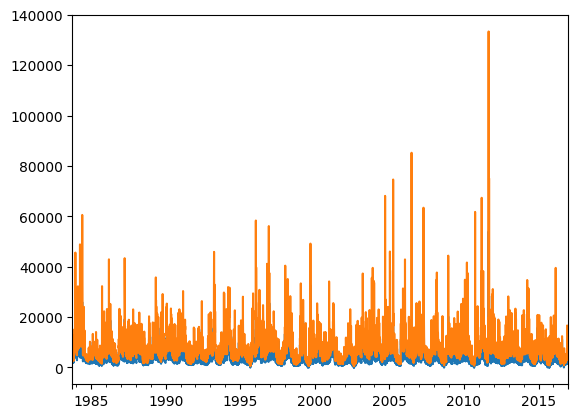

In [33]:
fig,ax=plt.subplots()
Q['pub_nwmv21']['01463500_marginal'].plot(ax=ax)
Q['pub_nwmv21']['01463500'].plot(ax=ax)


In [32]:
for model in pub_datasets:
    for s_marg in marginal_loo_sites:
        contributing_gauges = subcatchment_gauges[s_marg.split('_')[0]]
        if bad_gauge in contributing_gauges:
            contributing_gauges.remove(bad_gauge)
        Q[model][s_marg.split('_')[0]] = Q[model].loc[start_date:end_date, s_marg] + Q[model].loc[start_date:end_date, contributing_gauges].sum(axis=1)



###
fig,ax=plt.subplots()
ts = '01463500'
Q['obs'][ts].plot(c='k', ax=ax, ls='--')
Q['pub_nhmv10'][ts].plot(ax=ax, c = 'orange')

# Add the rest of flow
Q_stack_pred = Q['pub_nhmv10'][f'{ts}_marginal']

for sub in subcatchment_gauges[ts]:
    Q_stack_pred += Q['pub_nhmv10'][sub]
    
Q_stack_pred.plot(ax=ax, c='purple')
# Q['nhmv10'][ts].plot(c='green', ax=ax)

plt.xlim(['2000-01-01', '2013-01-01'])

,01484100,01484000,01483200,01483155,01411456,01478000,01478650,01481500,01464500,01465850,...,01414500,01413500,01481500_marginal,01474500_marginal,01463500_marginal,01472810_marginal,01447720_marginal,01438500_marginal,01423000_marginal,01422747_marginal
1983-10-01,0.059427,1.426250,0.059427,0.059427,5.705000,6.279556,19.683320,111.439418,29.403457,18.541250,...,2.852500,20.001642,102.822491,909.305311,2463.157282,12.836250,33.418099,469.836632,23.705408,1.426250
1983-10-02,0.059427,1.426250,0.059427,0.059427,5.719121,6.400160,28.525000,131.918763,34.051876,22.820000,...,2.852500,20.380191,120.449336,1059.493974,2904.076242,15.688750,34.359398,482.545952,23.970623,1.426250
1983-10-03,0.059427,1.426250,0.059427,0.059427,4.278750,5.798161,20.735719,110.651535,31.377497,19.967499,...,2.852500,18.201949,101.792926,658.788912,2578.833204,13.852660,32.397463,476.799997,20.272948,1.426250
1983-10-04,0.059427,1.426250,0.059427,0.059427,3.350008,5.104182,18.361192,98.074913,27.473126,17.115000,...,2.852500,20.428114,90.884236,603.115890,2203.808885,12.123269,29.784827,483.734526,18.456256,1.426250
1983-10-05,0.059427,1.426250,0.059427,0.059427,8.557500,4.782269,15.688748,97.924616,27.098749,17.115000,...,2.852500,24.972424,90.733939,1449.682174,2055.102057,12.836250,29.838465,510.219997,22.882524,1.426250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.059427,3.744511,0.059427,0.059427,4.278750,8.744918,34.502981,169.292022,42.174809,31.377497,...,35.539180,236.506230,155.029523,755.357076,2030.569836,23.311425,80.842543,3533.484008,272.181517,33.780951
2016-12-28,0.059427,2.889166,0.059427,0.059427,4.278750,8.523948,31.623440,162.370380,39.864502,28.525000,...,28.135823,199.099405,149.307933,752.916802,1768.829844,21.988960,88.023433,3380.898132,292.833124,35.745367
2016-12-29,0.902781,4.453884,0.059427,0.059427,8.758023,9.314596,46.008949,188.557313,46.176781,37.373956,...,25.441359,180.293213,173.989920,1411.688589,2576.473937,25.779290,86.010076,3160.194971,270.484141,31.298036
2016-12-30,1.426250,4.227936,0.059427,0.059427,5.705000,9.882260,42.787495,194.802092,47.408614,39.142421,...,24.924222,174.815911,178.218449,878.299736,2360.319700,30.637262,84.124895,3064.126467,261.477058,30.559607


In [3]:
### Load predictions using different numbers of K in QPPQ aggregate
k_min = 2
k_max = 8

for k in range(k_min, k_max):
    Q[f'pub_nhmv10_k{k}'] = pd.read_csv(f'../outputs/LOO/loo_reconstruction_nhmv10_K{k}.csv', index_col=0, parse_dates=True)
    Q[f'pub_nhmv10_k{k}'] = Q[f'pub_nhmv10_k{k}'].loc[start_date:end_date, loo_sites]
    
    Q[f'pub_nwmv21_k{k}'] = pd.read_csv(f'../outputs/LOO/loo_reconstruction_nwmv21_K{k}.csv', index_col=0, parse_dates=True)
    Q[f'pub_nwmv21_k{k}'] = Q[f'pub_nwmv21_k{k}'].loc[start_date:end_date, loo_sites]

In [36]:
# Get catchment areas
basin_areas = np.zeros(len(loo_sites))
for i, site in enumerate(loo_sites):
    basin_areas[i] = get_basin_catchment_area(feature_id=site,
                                              feature_source='nwissite')

In [34]:
#####################
### Error Metrics ###
#####################
k_max=7
k_min=6
summary_stats = ['nse', 'kge', 'r', 'alpha', 'beta',
                 'log_nse', 'log_kge', 'log_r', 'log_alpha', 'log_beta']
by_year = True

## Get error metrics for different predictions
error_sites = loo_sites
loo_summary = {}
error_datasets = ['nhmv10', 'nwmv21', 'pub_nhmv10', 'pub_nwmv21', 'pub_nhmv10_ens', 'pub_nwmv21_ens'] 
# error_datasets += [f'pub_nhmv10_k{k}' for k in range(k_min, k_max)]  
# error_datasets += [f'pub_nwmv21_k{k}' for k in range(k_min, k_max)]

for model in error_datasets:

    ## Error stats    
    if 'ens' in model:
        
        # Make a new dict to contain DFs with gauge meta and statistics of interest acros realizations
        loo_summary[model] = {}
        for site_number in (error_sites):
            n_realizations= Q[model][site_number].shape[1]
            
            # Obs flow
            if 'marginal' in site_number:
                Q_obs = Q['obs'].loc[start_date:end_date, site_number.split('_')[0]].dropna()
            else:
                Q_obs = Q['obs'].loc[start_date:end_date, site_number].dropna()
                
            loo_summary[model][site_number] = pd.DataFrame(index=range(n_realizations), 
                                                            columns = summary_stats)

            # Get errors for every realization
            for i in range(n_realizations):
                Q_sim = Q[model][site_number].loc[Q_obs.index, f'realization_{i}']
                
                loo_summary[model][site_number].loc[i, 'nse'] = he.evaluator(he.nse, Q_sim, Q_obs).flatten()[0]
                loo_summary[model][site_number].loc[i, ['kge', 'r', 'alpha', 'beta']] = he.evaluator(he.kge, Q_sim, Q_obs).flatten()
                
                loo_summary[model][site_number].loc[i, 'nse'] = he.evaluator(he.nse, Q_sim, Q_obs, transform='log').flatten()[0]
                loo_summary[model][site_number].loc[i, ['log_kge', 'log_r', 'log_alpha', 'log_beta']] = he.evaluator(he.kge, Q_sim, Q_obs,
                                                                                                                     transform='log').flatten()

    else:      
        # Make a new DF with gauge meta and statistics of interest    
        loo_summary[model] = pd.DataFrame(index=(error_sites), 
                                          columns=['comid', 'long', 'lat']+summary_stats)

        for site_number in error_sites:
            
            # Obs flow
            if 'marginal' in site_number:
                Q_obs = Q['obs'].loc[start_date:end_date, site_number.split('_')[0]].dropna()
                
                contributing_catchments = subcatchment_gauges[site_number.split('_')[0]]
                print(f'N contr: {len(contributing_catchments)}')
                
                Q_sim = Q[model].loc[Q_obs.index, [site_number] + contributing_catchments].sum(axis=1).values
            
            else:
                Q_obs = Q['obs'].loc[start_date:end_date, site_number].dropna()
                Q_sim = Q[model].loc[Q_obs.index, site_number].values
                
        
            # Store gauge meta
            loo_summary[model].loc[site_number, ['comid', 'long', 'lat']] = unmanaged_gauge_meta.loc[site_number.split('_')[0], ['comid', 'long', 'lat']]

            # Get errors   
            loo_summary[model].loc[site_number, 'nse'] = he.evaluator(he.nse, Q_sim, Q_obs).flatten()[0]
            loo_summary[model].loc[site_number, ['kge', 'r', 'alpha', 'beta']] = he.evaluator(he.kge, Q_sim, Q_obs).flatten()
            
            loo_summary[model].loc[site_number, 'log_nse'] = he.evaluator(he.nse, Q_sim, Q_obs, transform='log').flatten()[0]
            loo_summary[model].loc[site_number, ['log_kge', 'log_r', 'log_alpha', 'log_beta']] = he.evaluator(he.kge, Q_sim, Q_obs,
                                                                                                              transform='log').flatten()
            
            
## Re-arrange error metrics for single trace datasets
error_summary = pd.DataFrame(columns=['model', 'site', 'metric', 'value'])
for model in error_datasets[:-2]:
    for site in (error_sites):
        for metric in summary_stats:
            # add data to dataframe (do NOT use append)
            error_summary = pd.concat([error_summary, pd.DataFrame([[model, site, metric, loo_summary[model].loc[site, metric]]],
                                                columns=['model', 'site', 'metric', 'value'])])


In [9]:
error_summary.loc[error_summary['model'].isin(['pub_nhmv10', 'nhmv10']), :].head()

,model,site,metric,value
0,nhmv10,01484100,nse,0.472319
0,nhmv10,01484100,kge,0.452252
0,nhmv10,01484100,r,0.718937
0,nhmv10,01484100,alpha,0.578382
0,nhmv10,01484100,beta,0.791987


In [10]:
sort_by = 'na_fraction'
date_min = 1930
date_max = 2022
n_years = date_max - date_min

record_lengths =pd.to_datetime(unmanaged_gauge_meta['end_date']) -  pd.to_datetime(unmanaged_gauge_meta['begin_date'])

# Get NA count
site_na_counts = Q_observed.isna().sum()
total_length = len(Q_observed)
na_fraction = site_na_counts/total_length
na_fraction.index = [s.split('-')[1] for s in na_fraction.index]
na_fraction.sort_values(ascending=True, inplace=True)
bad_sites = []

for station in na_fraction.index:
    if na_fraction[station] > 0.85:
        bad_sites.append(station)

sorted_lat = unmanaged_gauge_meta.loc[:, 'lat'].sort_index(ascending=False)
sorted_record_lengths = record_lengths.sort_values(ascending=False)


sorted_flows = Q_observed.loc[:, [f'USGS-{s}' for s in sorted_record_lengths.index]]
sorted_flows.head()

if sort_by == 'record_length':
    sorted_index = sorted_record_lengths.index.drop(bad_sites)
elif sort_by == 'lat':
    sorted_index = sorted_lat.index.drop(bad_sites)
elif sort_by == 'na_fraction':
    sorted_index = na_fraction.index.drop(bad_sites)

grid = np.zeros((len(sorted_index), n_years))

for i, site in enumerate(sorted_index):
    for j in range(n_years):
        
        annual_flow = Q_observed.loc[f'{date_min+j}-01-01':f'{date_min+j}-12-31', f'USGS-{site}']
        na_count = annual_flow.isna().sum()
        
        if na_count < 20:
            grid[i, j] = 1.0


C:\Users\tjame\AppData\Local\Temp\ipykernel_6804\441462603.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(-10, len(sorted_index), 10), fontsize=16)


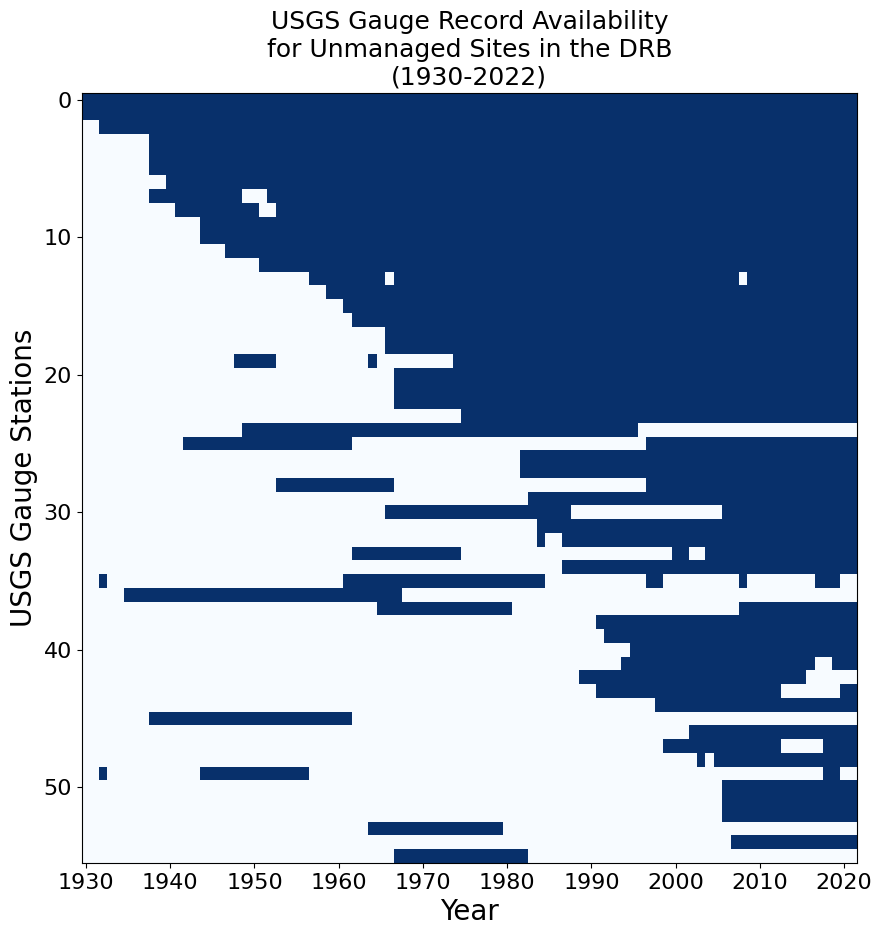

In [20]:
## Figure of record lengths

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(grid, cmap='Blues', aspect='auto')

## Format
# Set axis ticks as years
ax.set_xticks(range(0, n_years, 10))
ax.set_xticklabels(range(date_min, date_max, 10), fontsize=16)

ax.set_yticklabels(range(-10, len(sorted_index), 10), fontsize=16)

# Set axis labels
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('USGS Gauge Stations', fontsize=20)

# Set title
ax.set_title(f'USGS Gauge Record Availability\nfor Unmanaged Sites in the DRB\n({date_min}-{date_max})', fontsize=18)
plt.show()

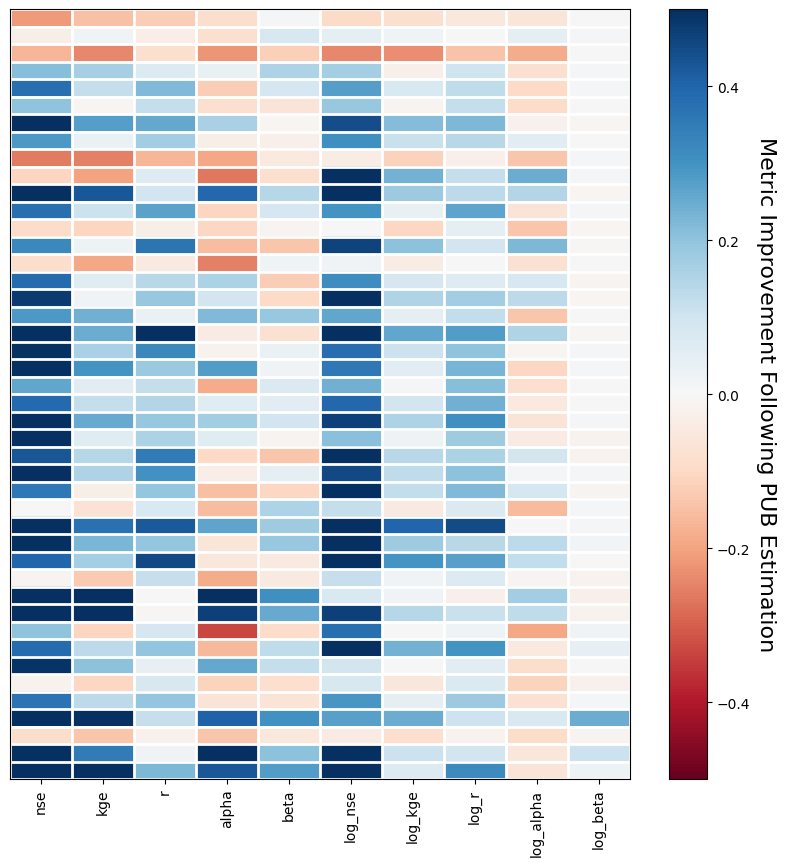

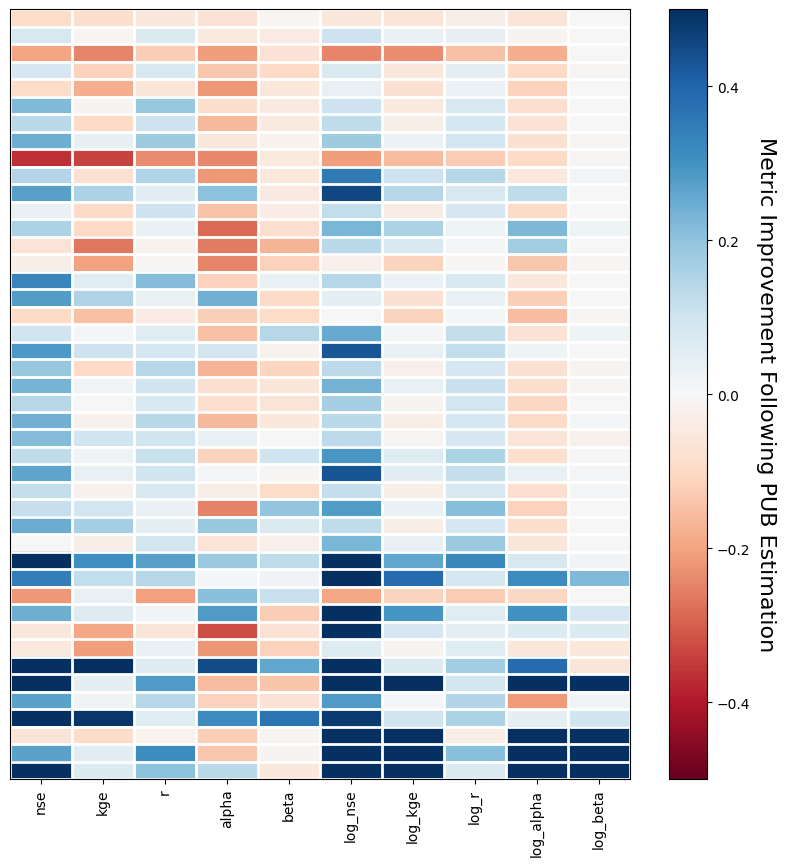

In [39]:
def plot_grid_metric_map(error_summary, donor_model, site_catchment_areas=None):
    VMAX = 0.5
    VMIN = -0.5
    
    # Pull data
    sites = error_summary['site'].unique()
    metrics = error_summary['metric'].unique()
    ideal_scores = 1.0 
    
    # Sort the sites by catchment area
    if site_catchment_areas is not None:
        sites = sites[np.argsort(site_catchment_areas)[::-1]]
    
    # Dimensions of the grid
    n_sites = len(sites)
    n_metrics = len(metrics)
    
    # Make a colormap
    model_colors = ['lightgrey', 'darkgreen']
    # cmap = ListedColormap(model_colors)
    cmap = mpl.colormaps.get_cmap('RdBu')
    
    # Create a NumPy array to store the best model information
    grid = np.zeros((n_sites, n_metrics))
    
    for i, site in enumerate(sites):
        site_errors = error_summary.loc[error_summary['site'] == site, :].copy()

        site_errors['abs_diff'] = abs(site_errors['value'] - 1.0)

        for j, metric in enumerate(metrics):
            site_metric_errors = site_errors.loc[site_errors['metric']==metric, :]
            donor_model_diff = site_metric_errors.loc[site_metric_errors['model']==donor_model, 'abs_diff'].values[0]
            pub_diff = site_metric_errors.loc[site_metric_errors['model']==f'pub_{donor_model}', 'abs_diff'].values[0]
            
            grid[i, j] = donor_model_diff - pub_diff

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(grid, aspect='auto',
              cmap=cmap, vmin=VMIN, vmax=VMAX)

    # Add grid lines
    for x in range(n_metrics + 1):
        ax.axvline(x - 0.5, color='white', lw=2)
    for y in range(n_sites + 1):
        ax.axhline(y - 0.5, color='white', lw=2)
    
    # Add metric labels
    ax.set_xticks(np.arange(0, n_metrics))
    ax.set_xticklabels(metrics, rotation=90)
    ax.set_yticklabels([])
    ax.set_yticks([])

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(f'Metric Improvement Following PUB Estimation', 
                       rotation=-90, fontsize=16, va='bottom')
    # cbar.yticklabels(fontsize=14)
    plt.show()
    return grid


metric_grid = plot_grid_metric_map(error_summary.loc[error_summary['model'].isin(['pub_nhmv10', 'nhmv10']), :],
                                   donor_model='nhmv10',
                                   site_catchment_areas=basin_areas)
metric_grid = plot_grid_metric_map(error_summary.loc[error_summary['model'].isin(['pub_nwmv21', 'nwmv21']), :],
                                   donor_model='nwmv21',
                                   site_catchment_areas=basin_areas)


ValueError: min() arg is an empty sequence

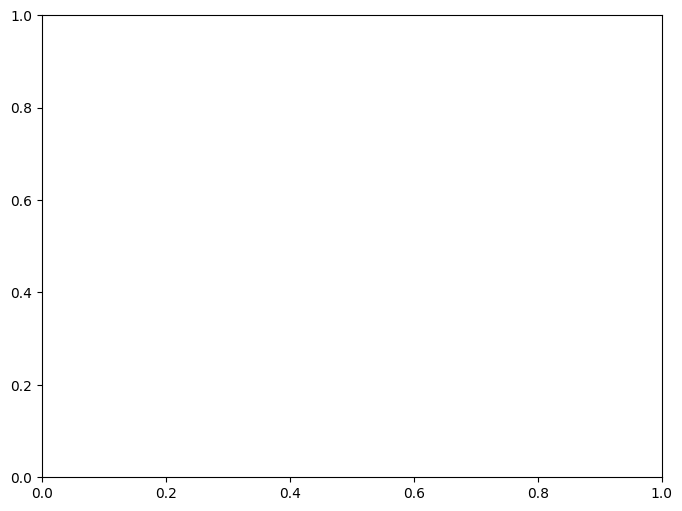

In [144]:
# Take only a subset of data for specific model types
error_dataset_subset = [f'pub_nhmv10_k{k}' for k in range(k_min, k_max)] + [f'pub_nwmv21_k{k}' for k in range(k_min, k_max)]
error_summary_subset = error_summary.loc[error_summary['model'].isin(error_dataset_subset)]

# Plot box plots by model for a specific metric
metric = 'alpha'
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='model', y='value', data=error_summary_subset.loc[error_summary_subset['metric'] == metric], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel(metric)
ax.set_title(f'LOO {metric} by model')
ax.set_ylim([0,1])
plt.tight_layout()


In [189]:
Q_observed.mean(axis=0).max()

7784.768814337949

C:\Users\tjame\AppData\Local\Temp\ipykernel_20300\3939236825.py:59: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


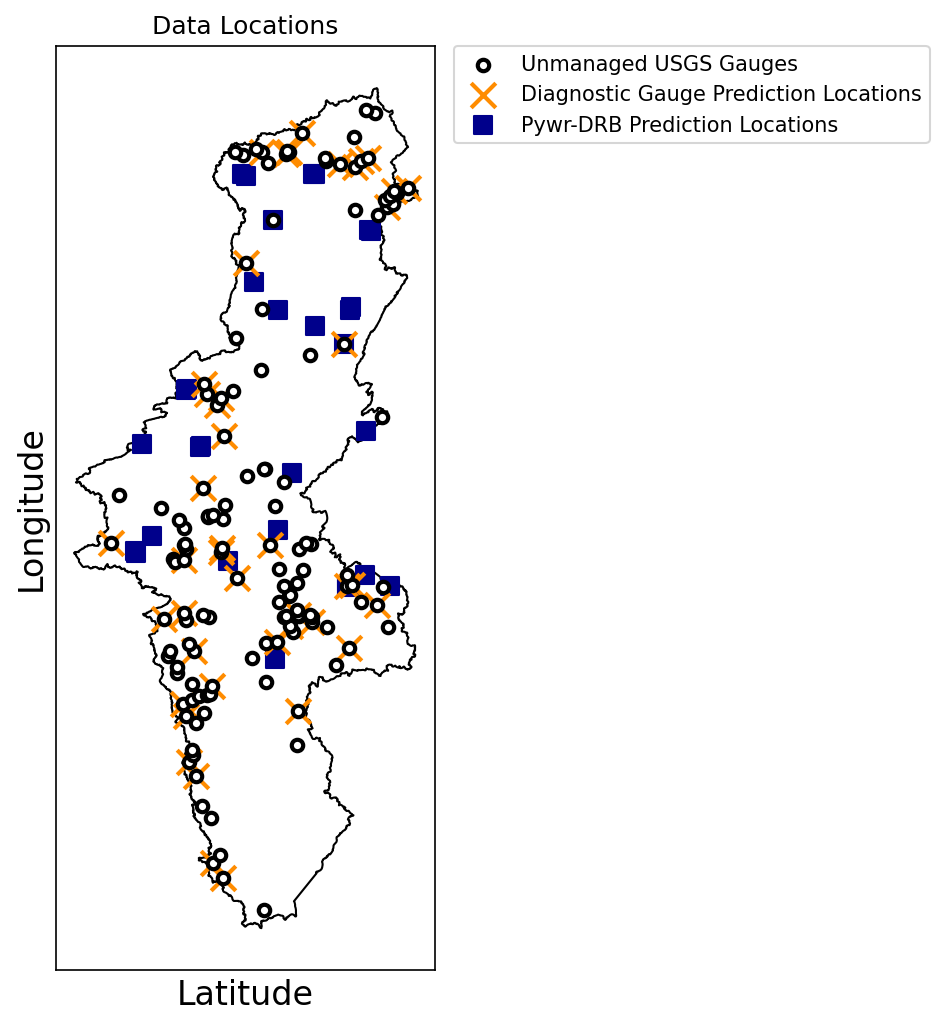

In [224]:
def make_data_summary_plot(unmanaged_gauge_meta, diagnostic_site_list, pywrdrb_node_metadata,
                           unmanaged_flow, 
                           drb_boundary, drb_mainstem, 
                           colorby_flow=True):
    
    marker_types = {'gauge': '.',
                    'diagnostic_site': 'x', 
                    'pywrdrb_node': 's'}
    marker_colors = {'gauge': 'black',
                    'diagnostic_site': 'darkorange',
                    'pywrdrb_node': 'darkblue'}
    marker_sizes = {'gauge': 30,
                    'diagnostic_site': 140,
                    'pywrdrb_node': 80}
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi = 150)
    
    ### Subplot 1: Map of sites
    # ax = axs[0]
    # Geo
    drb_boundary.plot(ax=ax, color='white', edgecolor='black', lw=1,
                      label = 'DRB Boundary', zorder=1)
    # drb_mainstem.plot(ax=ax, color='black', edgecolor='black', lw=2)
    
    # Plot gauges
    if colorby_flow:
        mean_flow = np.log(unmanaged_flow.mean(axis=0, skipna=True))
        ax.scatter(unmanaged_gauge_meta.loc[:, 'long'], unmanaged_gauge_meta.loc[:, 'lat'], 
                c=mean_flow, cmap = 'Blues',
                s=marker_sizes['gauge'], edgecolor='k', linewidth=2, zorder=4)
    else:
        ax.scatter(unmanaged_gauge_meta.loc[:, 'long'], unmanaged_gauge_meta.loc[:, 'lat'], 
                c='white',
                s=marker_sizes['gauge'], edgecolor='k', linewidth=2,
                zorder=4, label ='Unmanaged USGS Gauges')
    
    # Plot diagnostic sites
    ax.scatter(unmanaged_gauge_meta.loc[diagnostic_site_list, 'long'], unmanaged_gauge_meta.loc[diagnostic_site_list, 'lat'],
               c=marker_colors['diagnostic_site'], s=marker_sizes['diagnostic_site'], marker=marker_types['diagnostic_site'],
               lw=2, zorder=3, 
               label='Diagnostic Gauge Prediction Locations')
    
    # Plot pywrdrb nodes
    ax.scatter(pywrdrb_node_metadata.loc[:, 'long'], pywrdrb_node_metadata.loc[:, 'lat'],
               c=marker_colors['pywrdrb_node'], s=marker_sizes['pywrdrb_node'], marker=marker_types['pywrdrb_node'],
               zorder=2, label='Pywr-DRB Prediction Locations')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Data Locations')
    
    # Add colorbar
    if colorby_flow:
        # Add mappable
        cbar = plt.colorbar(ax=ax, orientation='horizontal', label='Mean Flow (log MGD)')
        
    # Set legend to the side
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    
    # Improve ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_ylabel('Longitude', fontsize=16)
    ax.set_xlabel('Latitude', fontsize=16)
    
    
    ### Subplot 2: Length of records
    # ax = axs[1]
    # date_min = '1920-01-01'
    # date_max= '2022-12-31'
    
    # # Plot gauge record lengths
    # record_lengths =pd.to_datetime(unmanaged_gauge_meta['end_date']) -  pd.to_datetime(unmanaged_gauge_meta['begin_date'])
    # sorted_record_lengths = record_lengths.sort_values(ascending=False)
    
    return

make_data_summary_plot(unmanaged_gauge_meta, loo_sites, prediction_locations, Q_observed, drb_boundary, drb_mainstem,
                       colorby_flow=False)

In [165]:
# Check how often the PUB is better than NHM or NWM

ideal_metric_scores = {'nse':1, 'kge':1, 'r':1, 'alpha':1, 'beta':1,
                       'log_nse':1, 'log_kge':1, 'log_r':1, 'log_alpha':1, 'log_beta':1}


metric='nse'

for metric in ideal_metric_scores.keys():
    counter=0
    for model in ['nwmv21', 'nhmv10']:
        for site in loo_sites:
            mod_score = loo_summary[model].loc[site, metric]
            pub_score = loo_summary[f'pub_{model}'].loc[site, metric]
            
            mod_diff = abs(mod_score - ideal_metric_scores[metric])
            pub_diff = abs(pub_score - ideal_metric_scores[metric])
            
            if mod_diff > pub_diff:
                counter+=1
    print(f'PUB is better than NHM or NWM {counter} out of {len(loo_sites)*2} times or {counter/(len(loo_sites)*2)*100}% of the time for {metric}')

PUB is better than NHM or NWM 67 out of 88 times or 76.13636363636364% of the time for nse
PUB is better than NHM or NWM 52 out of 88 times or 59.09090909090909% of the time for kge
PUB is better than NHM or NWM 70 out of 88 times or 79.54545454545455% of the time for r
PUB is better than NHM or NWM 30 out of 88 times or 34.090909090909086% of the time for alpha
PUB is better than NHM or NWM 36 out of 88 times or 40.909090909090914% of the time for beta
PUB is better than NHM or NWM 78 out of 88 times or 88.63636363636364% of the time for log_nse
PUB is better than NHM or NWM 57 out of 88 times or 64.77272727272727% of the time for log_kge
PUB is better than NHM or NWM 76 out of 88 times or 86.36363636363636% of the time for log_r
PUB is better than NHM or NWM 31 out of 88 times or 35.22727272727273% of the time for log_alpha
PUB is better than NHM or NWM 43 out of 88 times or 48.86363636363637% of the time for log_beta


(2.0, 0.0)

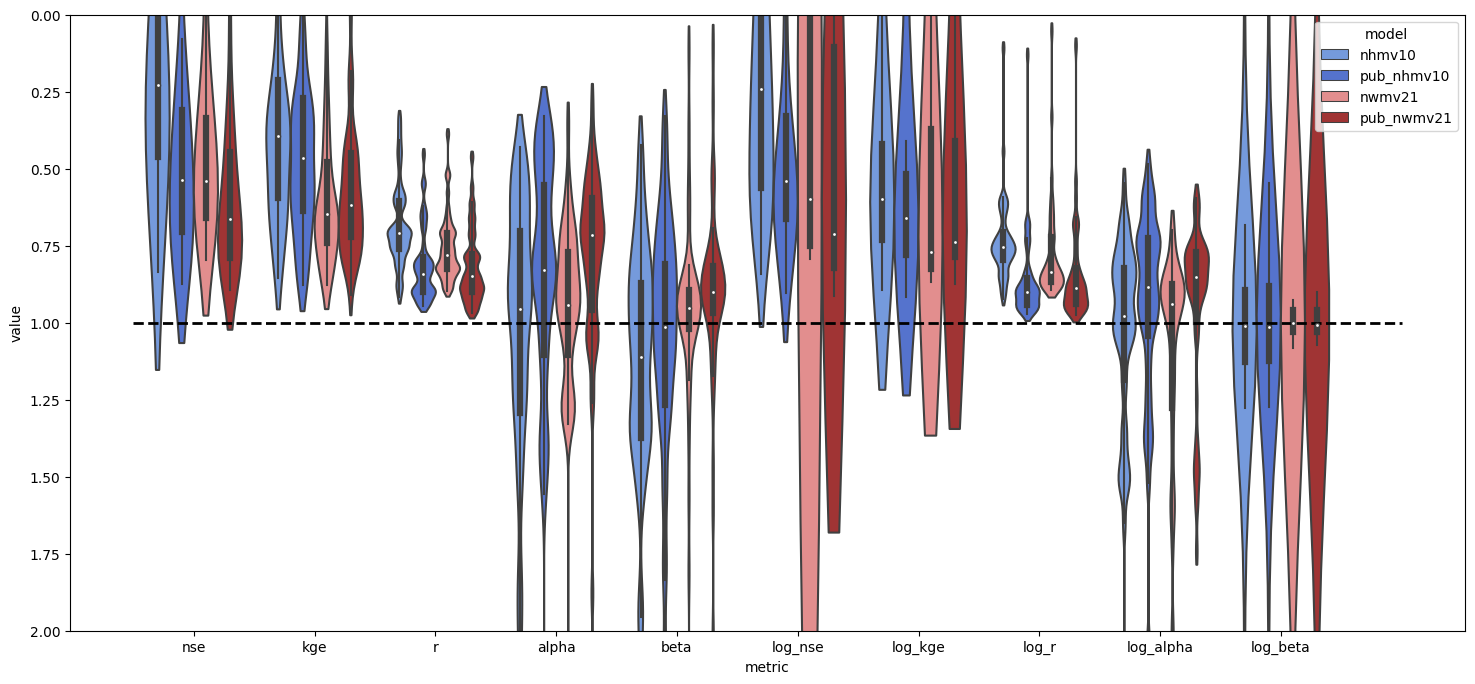

In [138]:
metric='r'

model_colors = {'nhmv10': 'cornflowerblue',
                'pub_nhmv10': 'royalblue',
                'nwmv21': 'lightcoral',
                'pub_nwmv21': 'firebrick'}

fig, ax = plt.subplots(figsize=(18, 8))
sns.violinplot(data=error_summary,
               x='metric', y='value', hue='model', inner='box', 
               ax=ax,
               hue_order= ['nhmv10', 'pub_nhmv10', 'nwmv21', 'pub_nwmv21'],
               palette=model_colors, 
               cut=1.0, bw=0.15, scale='width', alpha=0.5) 

# for i,model in enumerate(['nhmv10', 'pub_nhmv10', 'nwmv21', 'pub_nwmv21']):
#     plt.scatter(x=np.ones(len(loo_sites))*i*0.2-0.3, y=loo_summary[model].loc[:, metric], 
#                 s=75, alpha=0.2, color='k')

ax.hlines(1, -0.5, 10, color='k', linestyle='--', linewidth=2)
ax.set_ylim([2, 0])

In [7]:
### Calculate FDCs
## USGS
unmanaged_gauge_fdcs = pd.DataFrame(index = fdc_quantiles, columns = loo_sites)
for site_number in loo_sites:
    unmanaged_gauge_fdcs[site_number] = Q['obs'][f'USGS-{site_number}'].dropna().quantile(fdc_quantiles)


nhm_gauge_flows.loc[start_date:end_date, test_site]

## NHM
nhm_fdcs = pd.DataFrame(index = fdc_quantiles, columns = loo_sites)
for site_number in loo_sites:
    nhm_fdcs[site_number] = nhm_gauge_flows[site_number].dropna().quantile(fdc_quantiles)

## NWM

## Differences
# All NHM site matches

# Just LOO sites
fdc_diffs = nhm_fdcs - unmanaged_gauge_fdcs
fdc_percent_diffs = (nhm_fdcs - unmanaged_gauge_fdcs)/unmanaged_gauge_fdcs*100

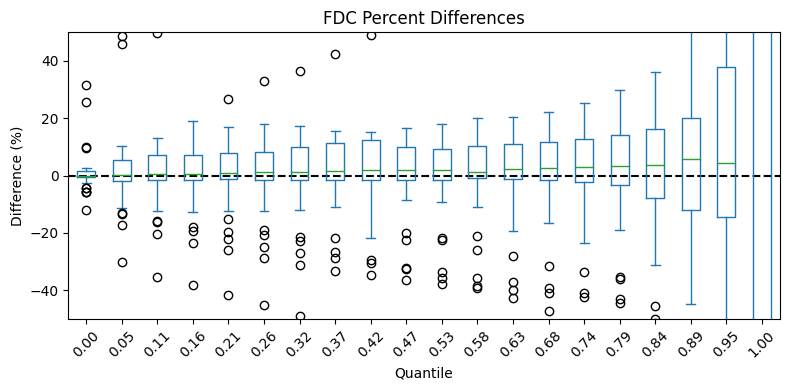

In [9]:
### Plot the distribution of FDC percent differences at each quantile
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.hlines(0, xmin=0.5, xmax=len(fdc_quantiles)+0.5, linestyle='--', color='k')
fdc_diffs.T.plot(kind='box', ax=ax)
ax.set_ylim([-50, 50])

# Reduce tick label to 2 decimal points and rotate xtick labels 
xtick_labels = ax.get_xticklabels()
ax.set_xticklabels([f'{float(x.get_text()):.2f}' for x in xtick_labels], rotation=45)

ax.set_ylabel('Difference (%)')
ax.set_xlabel('Quantile')
ax.set_title('FDC Percent Differences')
plt.tight_layout()



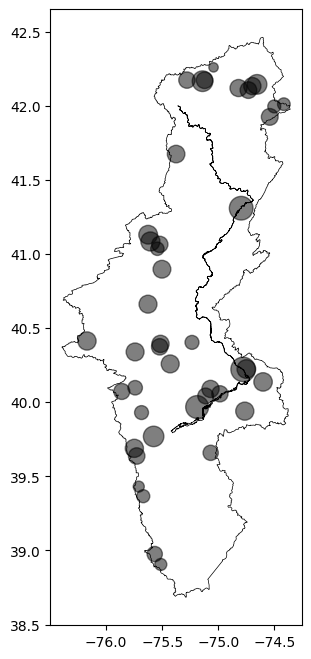

In [177]:
def get_basin_catchment_area(feature_id, feature_source='comid'):
    """Returns the catchment area of a comid.
    
    Args:
        feature_id (str): A comid or USGS number as a string.
        feature_source (str): 'comid' or 'usgs'. Defaults to 'comid'.
    Returns:
        float: The catchment area of the basin
    """
    cartesian_crs = 3857
    nldi = nhd.NLDI()
    basin_data = nldi.get_basins(fsource=feature_source, feature_ids=feature_id)
    area = basin_data.to_crs(cartesian_crs).geometry.area.values/10**6
    return area
    


site_numbers = loo_sites

## Plot spatial distribution of differences
fig, ax = plt.subplots(1,1, figsize=(8,8))

# Plot DRB boundary and mainstem
drb_boundary.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
drb_mainstem.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)

# Plot gauge locations with color by FDC difference at specified quantile
unmanaged_gauge_meta['geometry'] = gpd.points_from_xy(unmanaged_gauge_meta['long'], unmanaged_gauge_meta['lat'])

basin_areas = np.zeros(len(site_numbers))
for i, site in enumerate(site_numbers):
    basin_areas[i] = get_basin_catchment_area(feature_id=site,
                                              feature_source='nwissite')

marker_colors= np.zeros(len(site_numbers))
for i, site in enumerate(site_numbers):
    marker_colors[i] = error_summary.loc[(error_summary['model'] == 'pub_nhmv10') & (error_summary['site'] == site) & (error_summary['metric'] == 'nse'), 'value'].values[0]
                        

ax.scatter(unmanaged_gauge_meta.loc[site_numbers, 'long'], unmanaged_gauge_meta.loc[site_numbers, 'lat'], 
           c='k',
           s=np.log(basin_areas)*30, edgecolor='k', linewidth=1, alpha=0.5)

# Display the colorbar
# cbar = plt.colorbar(ax=ax, orientation='vertical', fraction=0.05, pad=0.05)
# cbar.set_label('NSE')


In [139]:
def get_loo_ensemble_error_metrics(loo_ensemble_streamflows, Q_obs,
                                   by_year=False):
    
    if (Q_obs.columns[0].split('-')[0] == 'USGS'):
        Q_obs.columns = [col.split('-')[1] for col in Q_obs.columns]
    
    # Pull info from ensemble results
    site_numbers = list(loo_ensemble_streamflows.keys())
    start_date = pd.to_datetime(loo_ensemble_streamflows[site_numbers[0]].index[0]).date()
    end_date = pd.to_datetime(loo_ensemble_streamflows[site_numbers[0]].index[-1]).date()

    for i, site in enumerate(site_numbers):
        site_ensemble_streamflows = loo_ensemble_streamflows[site]
        
        # Make df for site specific error metrics across ensemble
        site_ensemble_metrics = pd.DataFrame(index=loo_ensemble_streamflows[site_numbers[0]].columns.to_list(),
                                         columns=['nse', 'kge', 'r', 'alpha', 'beta'])
    
        # Loop through realizations (columns)
        for col in site_ensemble_streamflows.columns:
            site_realization_flows= site_ensemble_streamflows[col].values
            site_ensemble_metrics.loc[col, 'site_no'] = site
            
            if by_year:
                for yr in range(start_date.year, end_date.year+1):
                    
                    obs_flows = Q_obs.loc[Q_obs.index.year==yr, site].dropna()
                    if len(obs_flows) == 0:
                        continue
                    
                    site_realization_flows= site_ensemble_streamflows.loc[obs_flows.index, col].values
                    
                    site_ensemble_metrics.loc[col, 'year']= yr
                                    
                    site_ensemble_metrics.loc[col, 'nse'] = he.evaluator(he.nse, site_realization_flows,
                                                                            obs_flows).flatten()[0]
                    site_ensemble_metrics.loc[col, ['kge', 'r', 'alpha', 'beta']] = he.evaluator(he.kge, site_realization_flows,
                                                                                                  obs_flows).flatten()
            else:
                obs_flows= Q_obs.loc[start_date:end_date, site]
                site_realization_flows= site_ensemble_streamflows.loc[obs_flows.index, col].values
                
                site_ensemble_metrics.loc[col, 'nse'] = he.evaluator(he.nse, site_realization_flows, 
                                                                 obs_flows).flatten()[0]
                site_ensemble_metrics.loc[col, ['kge', 'r', 'alpha', 'beta']] = he.evaluator(he.kge, site_realization_flows,
                                                                                        obs_flows).flatten()
    
        # Store site specific metrics
        if i == 0:
            all_site_ensemble_metrics = site_ensemble_metrics
        else:
            all_site_ensemble_metrics = pd.concat([all_site_ensemble_metrics, site_ensemble_metrics], axis=0)
            
    return all_site_ensemble_metrics

# loo_ensemble_metrics = get_loo_ensemble_error_metrics(Q_pred_nhm_ensemble, Q['obs'], by_year=True)
agg_loo_ensemble_metrics = {}
agg_loo_ensemble_metrics['pub_nhmv10_ens'] = get_loo_ensemble_error_metrics(Q['pub_nhmv10_ens'], Q['obs'], by_year=False)
agg_loo_ensemble_metrics['pub_nwmv21_ens'] = get_loo_ensemble_error_metrics(Q['pub_nwmv21_ens'], Q['obs'], by_year=False)


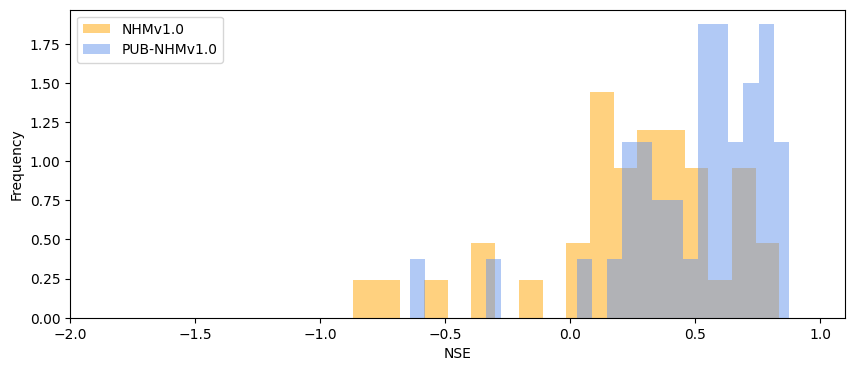

In [93]:

# Plot distribution of NSE
fig,ax =plt.subplots(1,1, figsize=(10,4))
loo_summary['nhmv10']['nse'].plot(kind='hist', density=True, bins=100, ax=ax, color='orange', alpha=0.5, xlim=[-10,1], label='NHMv1.0')
# loo_summary['nwmv21']['nse'].plot(kind='hist', density=True, color='green', bins=100, alpha=0.5, ax=ax, label ='NWMv2.1')
loo_summary['pub_nhmv10']['nse'].plot(kind='hist', density=True, bins=100, ax=ax, color='cornflowerblue', alpha=0.5, xlim=[-10,1], label='PUB-NHMv1.0')
# loo_summary['pub_nwmv21']['nse'].plot(kind='hist', density=True, color='darkblue', bins=100, alpha=0.5, ax=ax, label ='PUB-NWMv2.1')

ax.set_xlabel('NSE')
ax.set_xlim([-2,1.1])
plt.legend()

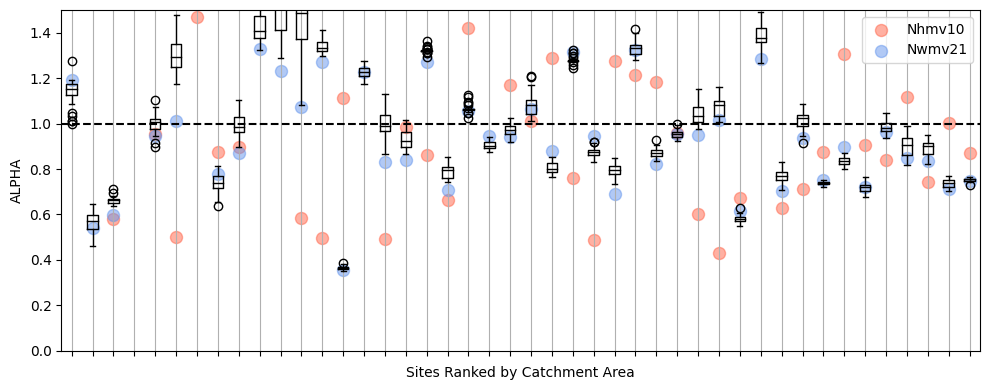

In [176]:

def plot_all_loo_sites_boxplot(ensemble_metrics, 
                               loo_summary,
                               metric_type='nse', colorby=None, 
                               colorby_label=None, colorby_cmap=None, colorby_vmin=None, colorby_vmax=None):
    
    basin_areas = np.zeros(len(site_numbers))
    for i, site in enumerate(site_numbers):
        basin_areas[i] = get_basin_catchment_area(feature_id=site,
                                                feature_source='nwissite')
    
    # Sort by basin area array
    sorted_loo_sites = list(np.array(site_numbers)[np.argsort(basin_areas)])
    
    # Sort sites by metric of interest
    # sorted_loo_sites = ensemble_metrics['pub_nwmv21_ens'].groupby('site_no').mean().sort_values(by=metric_type).index.to_list()
    
    # Create an empty DataFrame to collect site-specific metrics
    all_sites_df = pd.DataFrame()
    modeled_sites_metrics_df = pd.DataFrame(columns=['site_no', 'model', metric_type])
    
    # Loop through sorted sites to collect metrics
    for i, site in enumerate(sorted_loo_sites):
        
        site_ensemble_metrics = ensemble_metrics['pub_nwmv21_ens'].loc[ensemble_metrics['pub_nwmv21_ens']['site_no'] == site, metric_type]
        all_sites_df[site] = site_ensemble_metrics.reset_index(drop=True)
        
        for model in ['nhmv10', 'nwmv21']:
            site_model_metrics = loo_summary[model].loc[site, metric_type]
            mean_site_performance = np.mean(site_model_metrics)
            modeled_sites_metrics_df = pd.concat([modeled_sites_metrics_df, 
                                                  pd.DataFrame({'site_no':site, 
                                                                'model':model, 
                                                                metric_type: mean_site_performance}, index=[0])], axis=0, 
                                                 ignore_index=True)
    
    all_sites_df = all_sites_df.astype(float)
    
    ## Plotting
    fig, ax = plt.subplots(1,1, figsize=(10,4))
    
    # Plot boxplot for all sites
    all_sites_df.boxplot(column=sorted_loo_sites, ax=ax, color='k')
    
    # Add NHM and NWM metric as points
    for model in ['nhmv10', 'nwmv21']:
        mod_col = 'tomato' if model == 'nhmv10' else 'cornflowerblue'
        xs= np.arange(len(sorted_loo_sites)) +1
        ys = modeled_sites_metrics_df.loc[modeled_sites_metrics_df['model'] == model, metric_type]

        ax.scatter(x=xs, 
                   y=ys, 
                   s=75, alpha=0.5, color=mod_col, 
                   label=model.capitalize())
    
    ax.hlines(1, xmin=0.5, xmax=len(sorted_loo_sites) + 0.5, linestyle='--', color='k')
    # Turn of major gridlines
    ax.grid(False, axis='y')
    ax.set_xticklabels([], rotation=90)
    ax.set_ylabel(metric_type.upper())
    ax.set_ylim([-0, 1.5])
    ax.set_xlabel(f'Sites Ranked by Catchment Area')
    plt.legend()
    plt.tight_layout()
    

    return

plot_all_loo_sites_boxplot(agg_loo_ensemble_metrics, loo_summary=loo_summary, metric_type='alpha')

In [155]:
np.argsort([0.1, 1.5, 9.9])

array([0, 1, 2], dtype=int64)

In [99]:
loo_summary['pub_nhmv10']

,comid,long,lat,nse,kge,r,alpha,beta,log_nse,log_kge,log_r,log_alpha,log_beta
01484100,8077030,-75.51275,38.905778,0.382632,0.313707,0.698232,0.441584,0.739027,0.517642,0.498883,0.73498,0.609083,0.83247
01484000,8076762,-75.566917,38.976028,0.480748,0.260401,0.866157,0.397386,0.592631,0.728442,0.769003,0.916475,0.943444,0.792191
01483200,4653422,-75.669389,39.366278,0.441677,0.274151,0.804547,0.386513,0.664904,0.661762,0.595892,0.837131,0.647792,0.887189
01483155,4653400,-75.709472,39.430972,-2.159403,-0.998466,0.640127,1.37406,2.92988,-5.218601,-1.504504,0.730633,0.589928,3.455977
01411456,9481686,-75.0675,39.658889,-0.628311,0.319533,0.542218,1.50217,1.036013,0.356638,0.677055,0.682213,1.002191,0.942552
01478000,4651956,-75.727889,39.637389,0.595331,0.502066,0.812252,0.565651,0.844985,0.275915,0.519482,0.85831,1.433412,0.848424
01478650,4651944,-75.74875,39.689222,0.261925,-0.159082,0.842267,0.566473,2.063319,-1.04564,0.411979,0.933259,0.483659,1.273324
01481500,4655440,-75.576694,39.7695,0.60055,0.60121,0.785136,0.670683,1.066466,0.761202,0.829675,0.905081,0.862233,1.031959
01464500,4481607,-74.6,40.137222,0.214681,0.099657,0.748794,0.364331,0.413965,-0.853937,0.660919,0.860594,1.207436,0.770844
01465850,4492122,-74.763056,39.94,0.326302,0.243694,0.686322,0.328316,0.850182,0.603317,0.512761,0.84,0.540427,1.024365


In [14]:
loo_ensemble_metrics.loc[loo_ensemble_metrics['site_no'] == sorted_loo_sites[0], 'nse']
all_sites_df = pd.DataFrame()
for i, site in enumerate(sorted_loo_sites):
    site_ensemble_metrics = loo_ensemble_metrics.loc[loo_ensemble_metrics['site_no'] == site, 'nse']
    all_sites_df[site] = site_ensemble_metrics.reset_index(drop=True)


NameError: name 'loo_ensemble_metrics' is not defined

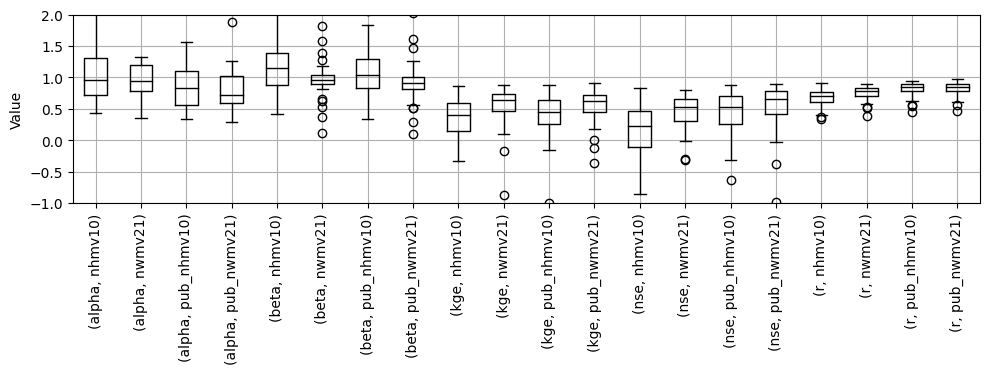

In [61]:
# Step 1: Rearrange the data
metrics = ['nse', 'kge', 'r', 'alpha', 'beta']
models = ['pub', 'nhm']
data_list = []

for metric in metrics:
    for model in ['pub_nhmv10', 'pub_nwmv21', 'nhmv10', 'nwmv21']:
        col_name= f'{model}_{metric}'
        temp_df = pd.DataFrame()
        temp_df[col_name] = loo_summary[model][[metric]].copy()
        temp_df['Metric'] = metric
        temp_df['Model'] = model
        temp_df.rename(columns={col_name: 'Value'}, inplace=True)
        data_list.append(temp_df)

# Combine all the small DataFrames into a single DataFrame
final_df = pd.concat(data_list)

# Step 2: Create a single boxplot
fig, ax = plt.subplots(figsize=(10, 4))

# Create a boxplot
final_df.boxplot(column='Value', by=['Metric', 'Model'], ax=ax, widths=0.5, color='k')

# Customize the plot
ax.set_title('')
plt.suptitle('')
ax.set_xlabel('')
ax.set_ylabel('Value')
ax.set_ylim([-1,2])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
test_site = loo_sites[1]
n_bootstrap = 1000
x=7
N=10

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['pub_nhmv10'].loc[start_date:end_date, test_site],x=x, N=N)
print(f'7Q10 for PUB-NHM is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['pub_nwmv21'].loc[start_date:end_date, test_site],x=x, N=N)
print(f'7Q10 for PUB-NWM is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['nhmv10'].loc[start_date:end_date, test_site],x=x, N=N)
print(f'7Q10 for NHM is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['nwmv21'].loc[start_date:end_date, test_site],x=x, N=N)
print(f'7Q10 for NWM is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['obs'].loc[start_date:end_date, f'USGS-{test_site}'],x=x, N=N)
print(f'7Q10 for Obs is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')